# Reproduction of figure 13

In this notebook we describe how to generate fig 13 from the paper.


In [1]:
import math
import numpy as np
from pylab import *
import os
import os.path
import json
import glycogen_module as gm
import random
import pandas as pd
import matplotlib.pyplot as plt

random.seed(123)  # add seed for reproducibility


## Generating data

As a example, we will generate de data needed to reproduce fig 13, top-left panel. For that, we set $\Gamma = 0.1$

Again, by default, we generate a small number of simulations (n = 5), with low molecular weight (N = 2500), to keep the computational time low (1 minute approx).

In [2]:
with open("parameters.json", "r") as f:
    parameters = json.load(f)
    
parameters['size_spec_gbe_spacing'] = 2
parameters['size_spec_gbe_leftover'] = 2
parameters['size_spec_gbe_transferred'] =2

parameters['GS'] = 0.1
parameters['GBE'] = 1.0
parameters['number_of_glucose_to_be_fixed']= 2500

number_of_simulations = 5

path_of_local_folder = os.getcwd()
folder_name = '/data_for_fig13'
os.mkdir(path_of_local_folder+folder_name)
data_path = path_of_local_folder+folder_name

In [3]:
from algorithm import Gillespie_step

In [4]:
C0 = {"GS":parameters['GS'],"GBE":parameters['GBE'],"GP":0.0,"GDE":0.0} 


for model in ['flexible','strict']:

    os.mkdir(data_path+'/'+str(model))
    folder_path =data_path+'/'+str(model)

    for i in range(number_of_simulations):

        my_granule = gm.glycogen_structure(parameters, 2,1)
        N = my_granule.number_of_glucose_fixed()  


        while N < parameters['number_of_glucose_to_be_fixed']:

            reaction, time = Gillespie_step(my_granule, C0)
            
            if reaction == 'Act_gs()':
                my_granule.Act_gs()
            elif reaction == 'Act_gp()':
                my_granule.Act_gp()
            elif reaction == 'Act_gbe()':
                if model == 'flexible':
                    my_granule.Act_gbe_flexible_model()
                elif model =='strict':
                    my_granule.Act_gbe_strict_location()
            elif reaction == 'Act_gde()':
                my_granule.Act_gde()

            N = my_granule.number_of_glucose_fixed()

        name = 'glycogen_structure'+str(len( os.listdir(folder_path) )+1)+'.json'
        my_granule.write_structure( folder_path+'/'+name) 

## reading the outputs:

### Requiered functions:

In [5]:
def cld(dict):
    histo=[]
    for chain in dict.values(): 
        histo.append(len(chain['glucose_location']))
    return histo 

def cumulative_cld(path_of_folder:str) -> array:
    cld_cumulated=[];

    for i in range(len(os.listdir(path_of_folder))):
        file_name='glycogen_structure'+str(i+1)+'.json'
        path=path_of_folder+'/'+file_name

        with open(path, "r") as f:
            my_granule_data = json.load(f)
        
        distrib = cld(my_granule_data)
        cld_cumulated= cld_cumulated + distrib

    return(cld_cumulated)

def plot_cld_from_distrib(liste):

    bins1 = np.linspace(0,max(liste), max(liste)+1)
    plt.figure(figsize=(14,7))
    plt.hist(liste, bins= bins1, color = 'grey', alpha =0.5, edgecolor = 'black', label = 'packed', density = 1)
    plt.xlabel('DP', fontsize = 20)
    plt.ylabel ('relative abundances', fontsize = 20)
    plt.legend()
    plt.tick_params(axis='both', which='major', labelsize=17)
    plt.xlim([0,50])
    plt.show()

def cumulative_cld(path_of_folder:str) -> array:
    cld_cumulated=[]

    for i in range(len(os.listdir(path_of_folder))):
        file_name='glycogen_structure'+str(i+1)+'.json'
        path=path_of_folder+'/'+file_name

        with open(path, "r") as f:
            my_granule_data = json.load(f)
        
        distrib = cld(my_granule_data)
        cld_cumulated= cld_cumulated + distrib

    return(cld_cumulated)

def hist_into_curve(distrib:list):
    'this function takes an histogram list and return X and Y arrays to plot the associated curve'
    
    total=len(distrib)
    maximum=max(distrib)
    #print(maximum)
    X=np.linspace(0,maximum,maximum+1)
    Y=[]
    for k in X:
        counter=0
        for i in range(len(distrib)):
            if k==distrib[i]:
                counter+=1
        Y.append(counter)   
    
    Y=np.asarray(Y)
    return X, Y*1.0/total

### Read the datafiles previously generated

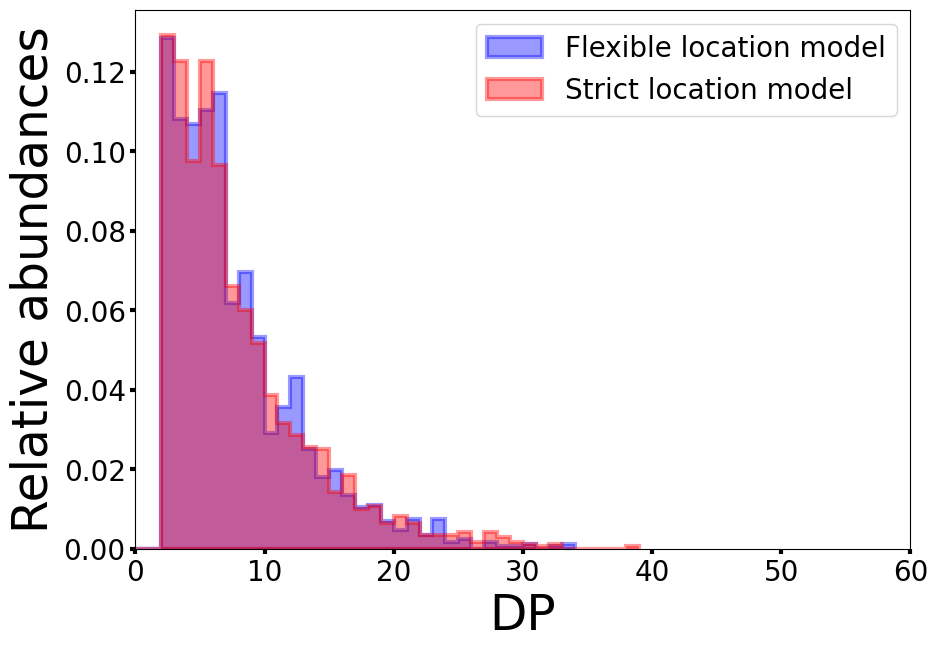

In [6]:
# paths to respectives datafiles
data1 =data_path+'/flexible'
data2 =data_path+'/strict'


distrib_1 = cumulative_cld(data1)
distrib_2 = cumulative_cld(data2)


bins1 = np.linspace(0,max(distrib_1), max(distrib_1)+1)
bins2 = np.linspace(0,max(distrib_2), max(distrib_2)+1)

figure(figsize=(10,7))

plt.hist(distrib_1,bins=bins1,histtype='stepfilled',color = 'blue', alpha=0.4, edgecolor='blue', density=True ,
linewidth=3,label=r'Flexible location model')
plt.hist(distrib_2,bins=bins2,histtype='stepfilled',color = 'red', alpha=0.4, edgecolor='red', density=True ,
linewidth=3,label=r'Strict location model')


plt.legend(prop={'size': 20})
plt.xlabel('DP',fontsize='35')
plt.ylabel('Relative abundances',fontsize='35')
plt.tick_params(axis='both',width=3,labelsize=20)
plt.xlim([0,60])
plt.show() 